# 5.12　专题：高斯混合模型

绍高斯混合模型，该模型可以被看作是 k-means
思想的一个扩展，但它也是一种非常强大的聚类评估工具。

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

In [38]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # 交换列是为了方便画图

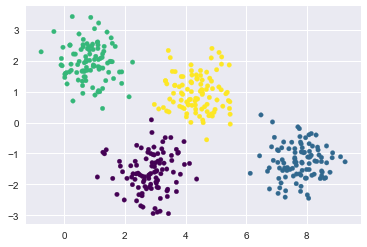

In [39]:
# plot the data with K-Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

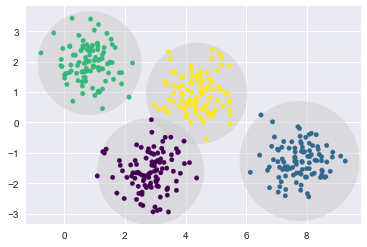

In [40]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', zorder=2)
    
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

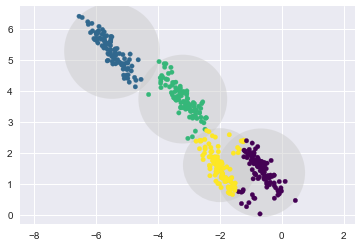

In [41]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

k-means 的这两个缺点——类的形状缺少灵活性、缺少簇分配的概率——使得它对许多数
据集（特别是低维数据集）的拟合效果不尽如人意。

## 一般化E-M：高斯混合模型

个高斯混合模型（Gaussian mixture model，GMM）试图找到多维高斯概率分布的混合
体，从而获得任意数据集最好的模型。

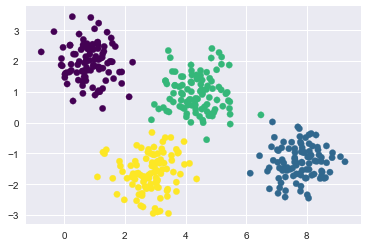

In [42]:
from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

predict_proba 方法实现。这个方法返回一个大小为 [n_samples, n_clusters]
的矩阵，矩阵会给出任意点属于某个簇的概率：

In [43]:
prob = gmm.predict_proba(X)
print(prob[:5].round(3))

[[0.    0.475 0.525 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]


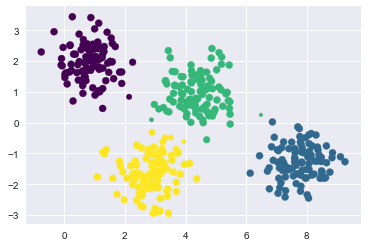

In [44]:
size = 50 * prob.max(1) ** 2 # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

<p>高斯混合模型本质上和 k-means 模型非常类似，它们都使用了期望最大化方法，具体实现
如下</p>
<p>(1) 选择初始簇的中心位置和形状。</p>
<p>(2) 重复直至收敛。<ul><li>a. 期望步骤（E-step）：为每个点找到对应每个簇的概率作为权重。</li><li> b. 最大化步骤（M-step）：更新每个簇的位置，将其标准化，并且基于所有数据点的权重来确定形状。</li></ul></p>


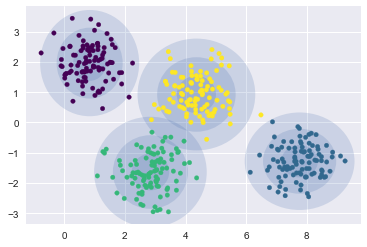

In [45]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转换成主轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance) # 奇异值分解
        angle = np.degrees(np.arctan2(U[1,0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle=0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=20, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

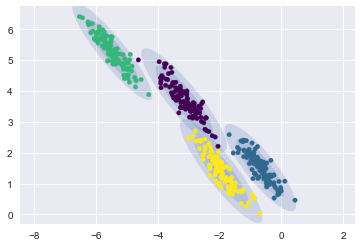

In [46]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

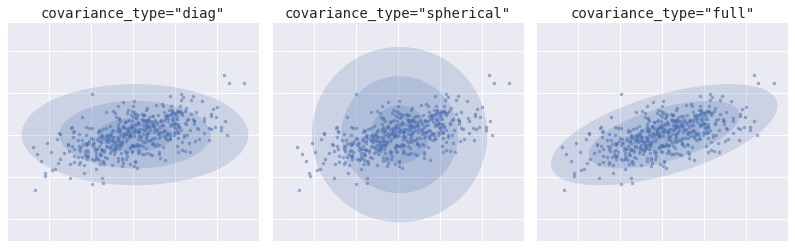

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4)) # sharex=True, sharey=True !!!!!!?
fig.subplots_adjust(wspace=0.05)

rng = np.random.RandomState(5)
X = np.dot(rng.randn(500, 2), rng.randn(2, 2))

for i, cov_type in enumerate(['diag', 'spherical', 'full']):
    model = GMM(1, covariance_type=cov_type).fit(X)
    ax[i].axis('equal')
    ax[i].scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)
    ax[i].set_xlim(-3, 3)
    ax[i].set_title('covariance_type="{0}"'.format(cov_type),
                    size=14, family='monospace')
    draw_ellipse(model.means_[0], model.covars_[0], ax[i], alpha=0.2)
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())

fig.savefig('figures/05.12-covariance-type.png')

## 将GMM用作密度估计

虽然 GMM 通常被归类为聚类算法，但它本质上是一个密度估计算法；也就是说，从技
术的角度考虑，一个 GMM 拟合的结果并不是一个聚类模型，而是描述数据分布的生成
概率模型。

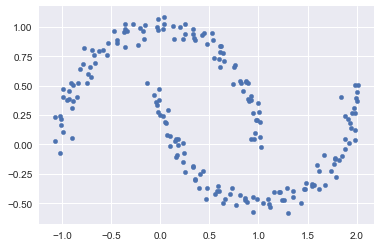

In [48]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], s=20);

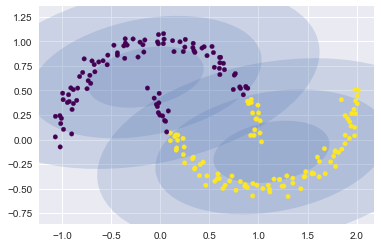

In [49]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

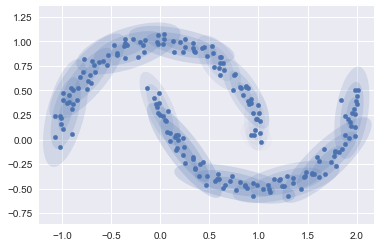

In [50]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

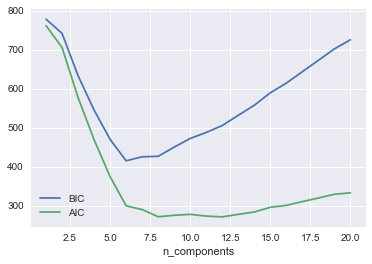

In [51]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [52]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

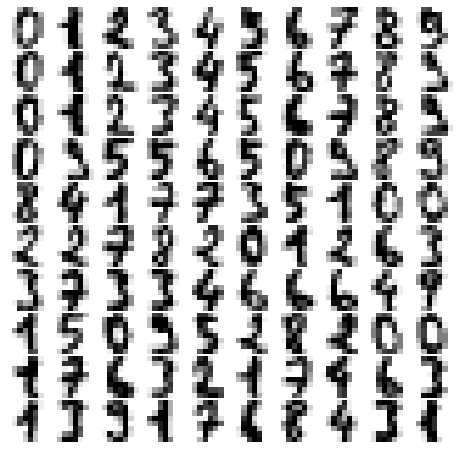

In [53]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

现在有大约 1800 个 64 维度的数字，可以创建一个 GMM 模型来生成更多的数字。GMM
在这样一个高维空间中可能不太容易收敛，因此先使用一个不可逆的降维算法。我们在这
里直接用 PCA，让 PCA 算法保留投影后样本数据 99% 的方差：

In [54]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

结果降到了 41 维，削减了接近 1/3 的维度的同时，几乎没有信息损失。再对这个投影数据
使用 AIC，从而得到 GMM 成分数量的粗略估计

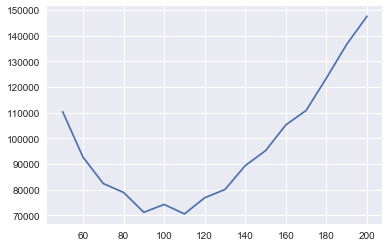

In [56]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

在大约 110 个成分的时候，AIC 是最小的，因此我们打算使用这个模型——立刻用它拟合
数据，并且确认它已经收敛：

In [57]:
gmm = GMM(100, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [58]:
data_new = gmm.sample(100, random_state=0)
data_new.shape

(100, 41)

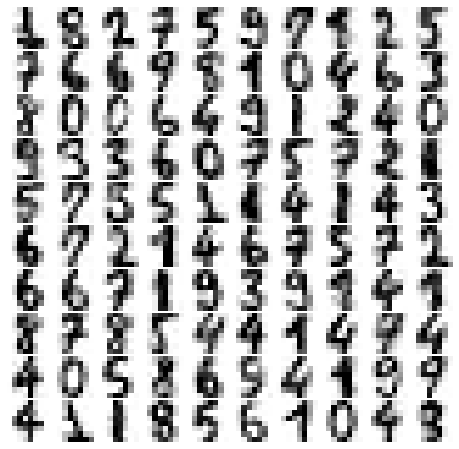

In [59]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)